In [224]:
import requests
import os
from dotenv import load_dotenv
import pandas as pd
import time
import random
from collections import defaultdict
from llm_comparison.generators import generate_tree, lca, tree_to_text, Tree
from tqdm.notebook import tqdm 
from dataclasses import dataclass
import seaborn as sns
import pandas as pd

In [197]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [198]:
load_dotenv()

True

In [199]:
API_KEY = os.getenv('OPENROUTER_API_KEY')
BASE_URL = "https://openrouter.ai/api/v1/chat/completions"

In [200]:
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [201]:
free_models = [
    "moonshotai/kimi-k2:free",
    "google/gemma-2-9b-it:free",
    "mistralai/mistral-7b-instruct:free",
    "anthropic/claude-sonnet-4",
    "deepseek/deepseek-chat-v3-0324:free",
    "google/gemini-2.0-flash-001",
]

In [202]:
def ask_model(prompt, model):
    """Send request to OpenRouter API"""
    payload = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 500,
        "temperature": 0.1
    }
    try:
        response = requests.post(BASE_URL, headers=headers, json=payload, timeout=30)
        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content'].strip()
        else:
            return f"Error: {response.status_code}"
    except Exception as e:
        return f"Failed: {str(e)}"

In [203]:
prompt = "What is 11 + 1? Answer with only the number, no explanation."

In [204]:
results = []

for model in free_models:
    print(f"\nTesting: {model}")
    response = ask_model(prompt, model)
    print(f"Response: {response}")
    
    results.append({
        'model': model,
        'response': response
    })


Testing: moonshotai/kimi-k2:free
Response: Error: 429

Testing: google/gemma-2-9b-it:free
Response: Error: 429

Testing: mistralai/mistral-7b-instruct:free
Response: Error: 429

Testing: anthropic/claude-sonnet-4
Response: 12

Testing: deepseek/deepseek-chat-v3-0324:free
Response: Error: 429

Testing: google/gemini-2.0-flash-001
Response: 12


### Trees visualisation examples

In [205]:
def layout_tree(tree, x=0, y=0, x_spacing=1, y_spacing=1):
    if tree is None:
        return {}, 0
    child_positions = []
    width = 0
    positions = {}
    for child in tree.children:
        child_pos, child_width = layout_tree(child, x + width, y - y_spacing, x_spacing, y_spacing)
        positions.update(child_pos)
        child_positions.append((child, width + child_width / 2))
        width += child_width + x_spacing
    if child_positions:
        child_xs = [x + cx for _, cx in child_positions]
        center_x = sum(child_xs) / len(child_xs)
    else:
        center_x = x
        width = 1
    positions[tree] = (center_x, y)
    return positions, width

def draw_tree(ax, tree):
    positions, _ = layout_tree(tree)
    for node, (x, y) in positions.items():
        circle = patches.Circle((x, y), 0.3, color='lightblue', ec='black')
        ax.add_patch(circle)
        # ax.text(x, y, str(node.value), ha='center', va='center', fontsize=8, weight='bold')
        for child in node.children:
            if child in positions:
                cx, cy = positions[child]
                ax.plot([x, cx], [y - 0.3, cy + 0.3], 'k-', linewidth=1)
    all_x, all_y = zip(*positions.values())
    ax.set_xlim(min(all_x) - 1, max(all_x) + 1)
    ax.set_ylim(min(all_y) - 1, max(all_y) + 1)
    ax.set_aspect('equal')
    ax.axis('off')

def visualize_tree_grid(trees_2d, parameters, figsize=(12, 8)):
    rows, cols = len(trees_2d), len(trees_2d[0])
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]
    for i in range(rows):
        for j in range(cols):
            draw_tree(axes[i][j], trees_2d[i][j])
            axes[i][j].set_title(f'Tree {parameters[i][j]}', fontsize=10)
    plt.tight_layout()
    plt.show()


In [206]:
trees = []
parameters = []
num_names = list(map(str, range(20)))
for size in [4, 6, 10, 15, 20]:
    parameters.append([])
    trees.append([])
    for density in [2, 3, 4, 6]:
        trees[-1].append(generate_tree(size=size, density=density, names=num_names))
        parameters[-1].append(f"size={size}, density={density}")


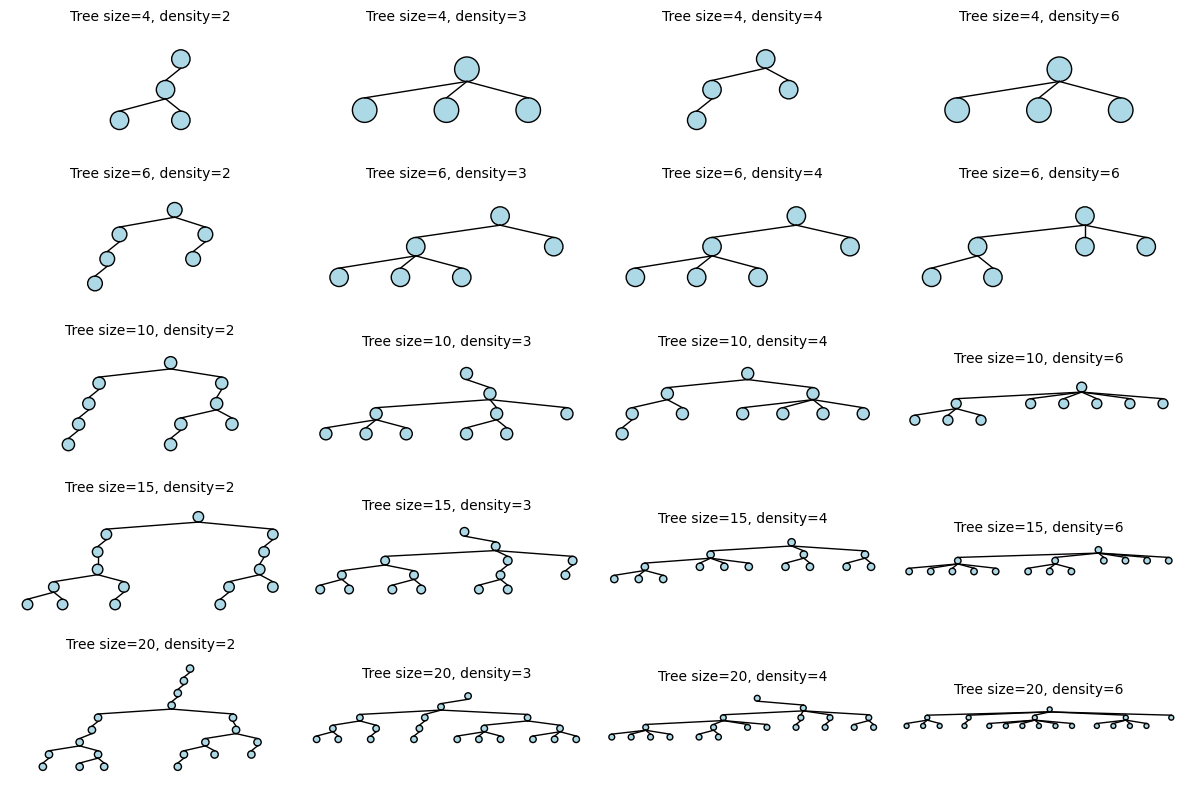

In [207]:
visualize_tree_grid(trees, parameters)

In [209]:
# for row in trees:
#     for tree in row:
#         print(tree_to_text(tree))


### Dataset TreeQuest for LLM's

In [210]:
names = []
with open("../data/random_names.txt") as names_file:
    for name in names_file:
        names.append(name.strip())

In [211]:
# (size, density) -> [(tree, text, query, answer)]

@dataclass
class QAExample:
    tree: Tree
    text: str
    query: str
    answer: str


In [235]:
dataset = defaultdict(list)
sample_nums = 3
tree_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 99]
densities = list(range(2, 10))
for size in tree_sizes:
    for density in densities:
        for _ in range(sample_nums):
            tree = generate_tree(size=size, density=density, names=names)
            text_description = tree_to_text(tree)
            [q, p] = random.choices(names[0: size - 1], k=2)
            query = f"Who is lowest (youngest) common ancestor for {q} and {p}? Only name, one name, nothing else."
            answer = lca(tree=tree, p=p, q=q)
            dataset[(size, density)].append(
                QAExample(
                    tree,
                    text_description,
                    query,
                    answer
                )
            )

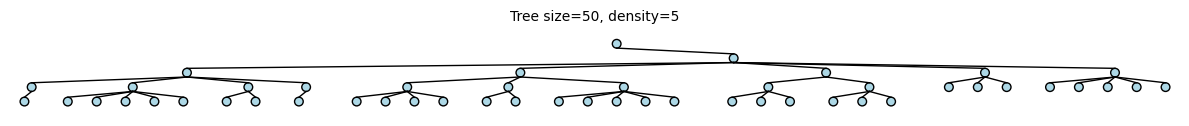

In [236]:
k = (50, 5)
param = f"size={k[0]}, density={k[1]}"
visualize_tree_grid([[dataset[k][0].tree]], [[param]])

In [237]:
print(dataset[k][0].text + "\n" + dataset[k][0].query)

Oberon is parent for Cyra. Cyra is parent for Riven and Elspeth and Kenji and Ophelia and Marek. Riven is parent for Zuleika and Ronan and Iskra and Elio. Elspeth is parent for Vesper and Tarek and Aisling. Kenji is parent for Rune and Elira. Ophelia is parent for Malachai and Zinnia and Leif. Marek is parent for Briony and Noa and Evren and Thalia and Alaric. Zuleika is parent for Azura. Ronan is parent for Jovan and Calista and Eirik and Xanthe and Orin. Iskra is parent for Solene and Lucian. Elio is parent for Yvaine. Vesper is parent for Kael and Mireille and Idris and Anouk. Tarek is parent for Soren and Lyra. Aisling is parent for Cassian and Amara and Dorian and Isolde and Zephyr. Rune is parent for Nyla and Thorne and Elowen. Elira is parent for Kairos and Seraphina and Aurelian. Malachai is parent for no one. Zinnia is parent for no one. Leif is parent for no one. Briony is parent for no one. Noa is parent for no one. Evren is parent for no one. Thalia is parent for no one. Al

In [238]:
dataset[k][0].answer

'Cyra'

### API Models Benchmark

In [239]:
tree_requests_results = defaultdict(list)
model = free_models[-1]
print(f"{model} is testing")
for (size, density), qa_samples in tqdm(dataset.items()):
    for qa_sample in qa_samples:
        prompt = f"{qa_sample.text} {qa_sample.query}" 
        response = ask_model(prompt, model)
        tree_requests_results[(size, density)].append((response, qa_sample.answer))
        print(qa_sample.query, response, qa_sample.answer)
        time.sleep(3)

google/gemini-2.0-flash-001 is testing


  0%|          | 0/72 [00:00<?, ?it/s]

Who is lowest (youngest) common ancestor for Isolde and Nyla? Only name, one name, nothing else. Dorian Isolde
Who is lowest (youngest) common ancestor for Isolde and Kairos? Only name, one name, nothing else. Dorian Isolde
Who is lowest (youngest) common ancestor for Thorne and Seraphina? Only name, one name, nothing else. Isolde Isolde
Who is lowest (youngest) common ancestor for Elowen and Nyla? Only name, one name, nothing else. Dorian Dorian
Who is lowest (youngest) common ancestor for Kairos and Dorian? Only name, one name, nothing else. Isolde Amara
Who is lowest (youngest) common ancestor for Elowen and Elowen? Only name, one name, nothing else. Zephyr Elowen
Who is lowest (youngest) common ancestor for Dorian and Zephyr? Only name, one name, nothing else. Amara Amara
Who is lowest (youngest) common ancestor for Dorian and Elowen? Only name, one name, nothing else. Dorian Dorian
Who is lowest (youngest) common ancestor for Elowen and Aurelian? Only name, one name, nothing else.

In [240]:
tree_requests_results

defaultdict(list,
            {(10, 2): [('Dorian', 'Isolde'),
              ('Dorian', 'Isolde'),
              ('Isolde', 'Isolde')],
             (10, 3): [('Dorian', 'Dorian'),
              ('Isolde', 'Amara'),
              ('Zephyr', 'Elowen')],
             (10, 4): [('Amara', 'Amara'),
              ('Dorian', 'Dorian'),
              ('Isolde', 'Isolde')],
             (10, 5): [('Amara', 'Amara'),
              ('Amara', 'Amara'),
              ('Dorian', 'Dorian')],
             (10, 6): [('Dorian', 'Dorian'),
              ('Amara', 'Amara'),
              ('Dorian', 'Dorian')],
             (10, 7): [('Amara', 'Thorne'),
              ('Amara', 'Amara'),
              ('Amara', 'Amara')],
             (10, 8): [('Amara', 'Amara'),
              ('Amara', 'Amara'),
              ('Amara', 'Amara')],
             (10, 9): [('Amara', 'Amara'),
              ('Amara', 'Amara'),
              ('Amara', 'Amara')],
             (20, 2): [('Cassian', 'Soren'),
              ('Yva

In [243]:
print(dataset[(10, 2)][0].text + "\n" + dataset[(10, 2)][0].query)

Amara is parent for Dorian. Dorian is parent for Isolde. Isolde is parent for Zephyr. Zephyr is parent for Nyla and Thorne. Nyla is parent for Elowen. Thorne is parent for Kairos and Seraphina. Elowen is parent for Aurelian. Kairos is parent for no one. Seraphina is parent for no one. Aurelian is parent for no one
Who is lowest (youngest) common ancestor for Isolde and Nyla? Only name, one name, nothing else.


In [244]:
tree_requests_error = {}
for k, v in tree_requests_results.items():
    tree_requests_error[k] = sum(response == answer for response, answer in v) / len(v)

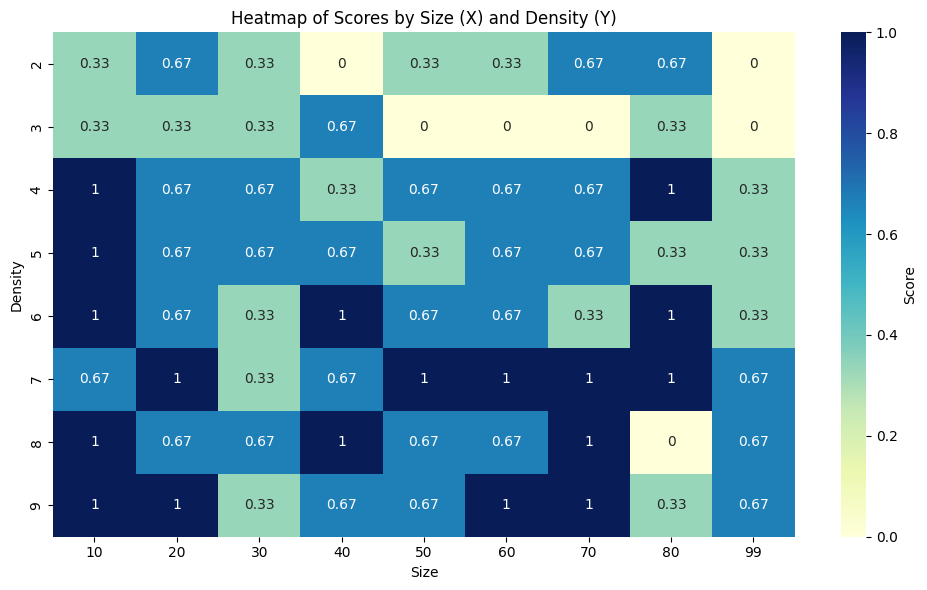

In [245]:
df = pd.DataFrame(
    {(size, density): value for (size, density), value in tree_requests_error.items()},
    index=[0]
).T.reset_index()

df.columns = ['size', 'density', 'value']

# Pivot for heatmap: rows=density, cols=size
heatmap_data = df.pivot(index='density', columns='size', values='value')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label': 'Score'})
plt.title('Heatmap of Scores by Size (X) and Density (Y)')
plt.xlabel('Size')
plt.ylabel('Density')
plt.tight_layout()
plt.show()